In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 
from scipy.linalg import null_space, cholesky, inv, svd
from scipy.interpolate import interp2d
%matplotlib inline
from helper import *
# get_H()
DEBUG = True



400 600


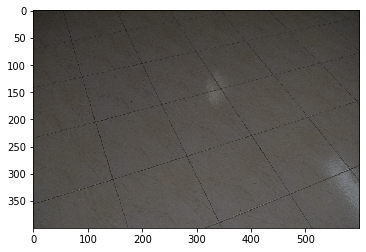

In [2]:
path = './Images/Image1.JPG'
img = cv2.imread(path)
img = cv2.resize(img,(img.shape[1]//10,img.shape[0]//10),fx=4,fy=4)
plt.imshow(img[:,:,::-1])
height, width = img.shape[:2]
print(height,width)

In [3]:
plt.imshow(img2[:,:,::-1])

NameError: name 'img2' is not defined

In [3]:
point_list = np.array([[2360,1736,2400,1750],[4416,1200,4525,1750],[3416,3904,2400,4162],[5816,2920,4525,4162]])
point_list = point_list//10
print(point_list)
cv2.imwrite('resized.png',img)
H = get_H(point_list)
print(H)

[[236 173 240 175]
 [441 120 452 175]
 [341 390 240 416]
 [581 292 452 416]]
[[240 175]
 [452 175]
 [240 416]
 [452 416]]
Homography estimate:  [-4.42763362e-03  2.84799985e-04 -4.00802203e-01 -1.70313661e-03
 -8.85782996e-03  9.16097597e-01  1.20242471e-06 -8.32183248e-06
 -4.66265079e-03]
[[ 9.49595802e-01 -6.10811313e-02  8.59601589e+01]
 [ 3.65272178e-01  1.89974123e+00 -1.96475704e+02]
 [-2.57884358e-04  1.78478571e-03  1.00000000e+00]]


In [4]:
def blur(arr,arr2,ind,size=3):
    if size%2:
        try :
            seq = [arr[tuple([ind[0]+i,ind[1]+j,ind[2]])] for i in range((-size+1)//2,(size+1)//2) for j in range((-size+1)//2,(size+1)//2)]
            arr2[tuple(ind)] = max(seq) 
#             print('SEQUENCE',seq)
        except IndexError:
#             seq = [arr[tuple([ind[0]+i,ind[1]+j,ind[2]])] for i in range((-size+1)//2,(size-1)//2) for j in range((-size+1)//2,(size-1)//2)]
            pass

def get_arr_from_H(img,width,height,H,size=False,scale=False,buf=50):
    grid = construct_grid(img.shape[1],img.shape[0],True)
    if scale :
        diag = np.diag([1/width, 1/height, 1])
        H = inv(diag)@H@diag
    # print(H_perp.shape)
    aff_grid = np.matmul(H,grid)
        
#     aff_grid[0] = aff_grid[0]*width
#     aff_grid[1] = aff_grid[1]*height
    if DEBUG:
        print(aff_grid.shape)
    x_aff = np.round(np.divide(aff_grid[0],aff_grid[2])).astype(int)    
    y_aff = np.round(np.divide(aff_grid[1],aff_grid[2])).astype(int)
    if DEBUG:
        print("X_aff max, min :",max(x_aff),min(x_aff))
        print("y_aff max:",max(y_aff),min(y_aff))
   
    x_aff -= buf
    y_aff -= buf
    if min(x_aff) < buf:
        x_aff -= min(x_aff)
        y_aff -= min(y_aff)
    if DEBUG:
        print("X_aff max, min :",max(x_aff),min(x_aff))
        print("y_aff max:",max(y_aff),min(y_aff))
    a, b = max(x_aff), max(y_aff)
    if not size :
        inds = np.where((x_aff>= 0) & (y_aff>=0) & (x_aff<width) & (y_aff<height))
        aff = np.zeros((height,width,3))
    else :
        inds = np.where((x_aff>=0) & (y_aff>=0) & (x_aff<max(x_aff)) & (y_aff<max(y_aff)))
        aff = np.zeros(shape=(max(y_aff),max(x_aff),3),dtype=float)
    x_aff,y_aff = x_aff[inds],y_aff[inds]
#     print(x_aff)
    if DEBUG:
        print("X_aff max, min :",max(x_aff),min(x_aff))
        print("y_aff max:",max(y_aff),min(y_aff))
#         print(np.sum(x_aff<1000))
        
    xx,yy =  grid[0][inds], grid[1][inds]
    
    aff[y_aff,x_aff] = img[yy, xx]
    zeros = np.array(np.where(aff==0))
    aff1 = aff.copy()
    nzs = np.where(aff != 0)
    for ind in zeros.T:
        blur(aff,aff1,ind,5)
#         break
#         except Exception as e:
#             print(e)
#             continue

    if DEBUG :
        print(np.max(aff))
    kernel = np.ones((5,5),np.float32)/25

#     aff = cv2.filter2D(aff,-1,kernel)
    
#     aff = cv2.resize(aff,(img.shape[1],img.shape[0]))

    aff1[nzs] = aff[nzs]
    return aff1 

def get_arr(img,H,shape=(600,400),tx=0,ty=0):
    grid = construct_grid(img.shape[1],img.shape[0],True)
    aff_grid = np.matmul(H,grid)
    x_aff = np.round(np.divide(aff_grid[0],aff_grid[2])).astype(int)    
    y_aff = np.round(np.divide(aff_grid[1],aff_grid[2])).astype(int)
    
    if not tx and not ty:
        x_max, x_min = max(x_aff),min(x_aff)
        y_max, y_min = max(y_aff), min(y_aff)
        tx, ty = [-1*x_min,-1*y_min]
        print('translations added',tx,ty)
        print('Maximas : ',x_max,y_max)
    transl_matrx = np.array([[1,0,tx],[0,1,ty],[0,0,1]])
    new_H = transl_matrx@H
    return cv2.warpPerspective(img,new_H,shape,flags=cv2.INTER_CUBIC)
        
        
    


(3, 240000)
X_aff max, min : 774 36
y_aff max: 501 -196
X_aff max, min : 738 0
y_aff max: 697 0
X_aff max, min : 499 2
y_aff max: 499 0
119.0
(500, 500, 3)
[[236 173 240 175]
 [441 120 452 175]
 [341 390 240 416]
 [581 292 452 416]]


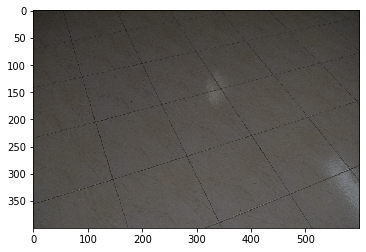

In [8]:
# a = cv2.warpPerspective(img,H,(width,height))
a = get_arr_from_H(img,500, 500,H)
plt.imshow(img[:,:,::-1].astype(int))
print(a.shape)
print(point_list)

In [5]:
points3_1 = np.array([[1140,1080,1000,1080],[2936,768,2800,1080],[1720,2928,1000,2880],\
                     [3832,2216,2800,2880]])
points3_1= points3_1//10
img3 = cv2.imread('./Images/Image3.JPG')
img3 = cv2.resize(img3,(img3.shape[1]//10,img3.shape[0]//10))
H3 = get_H(points3_1)
a = get_arr(img3,H3)
# plt.imshow(a[:,:,::-1].astype(int))
lines3_3 = get_five_pairs(points3_1[:,:2])
conic = get_conic(lines3_3)
H = get_H_from_conic(conic)
# img2 = cv2.imread('./Images/Image2.JPG')
# img2  = cv2.resize(img2,(img2.shape[1]//4,img2.shape[0]//4))
a = get_arr(img3,inv(H),(800,600))
plt.imshow(a[:,:,::-1])

[[100 108]
 [280 108]
 [100 288]
 [280 288]]
Homography estimate:  [ 1.24135877e-02 -1.44462336e-03  3.47766643e-01  2.59016929e-03
  2.20120350e-02 -9.37131052e-01 -7.61155065e-06  2.70828469e-05
  1.40117325e-02]
translations added 9 67
Maximas :  823 464


NameError: name 'get_five_pairs' is not defined

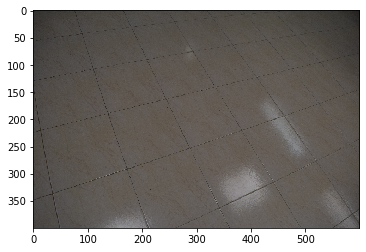

In [10]:
plt.imshow(img3[:,:,::-1])

## Question 2 

In [6]:
# lines = np.array([[0.2607,1,-2351.25],[0.410,1,-5304.56],[1.228,-1,-4225.37],[2.053,-1,-3109.150]])
points = np.hstack([point_list[:,:2],np.ones((4,1))])
lines = np.stack([get_line(points[0],points[1]),get_line(points[2],points[3]),\
                    get_line(points[0],points[2]),get_line(points[1],points[3])])
l_inf = get_l_inf(lines)
H_perp = np.array([[1,0,0],[0,1,0],l_inf])

lines_perp = get_transf_line(lines,H_perp)
# print(lines_perp[:2])
try :
    lines_perp = np.array([line/line[-1] for line in lines_perp])
    print(lines_perp)
except Exception:
    pass


s = construct_P(lines_perp[[0,2]],lines_perp[[1,2]])


        
kkt = np.array([[s[0],s[1]],[s[1],s[2]]]).reshape(2,2)
u,d,_ = svd(kkt)

# print(u,d)
k = np.matmul(u,np.diag(np.sqrt(d)))
k = k* np.sign(k[0,0])
transformed = (H_perp@points.T).T
# print(k)
transformed = [point/point[-1] for point in transformed]
H_aff = np.array([[k[0][0],k[0][1],0],[k[1][0],k[1][1],0],\
                 [0,0,1]])
# print(transformed)
# print(get_line(transformed[2],transformed[0]))


NameError: name 'get_transf_line' is not defined

In [10]:

print(inv(H_aff))

[[ 0.98769244 -0.13370968 -0.        ]
 [-0.5842669  -4.31588781  0.        ]
 [ 0.          0.          1.        ]]


31 1330


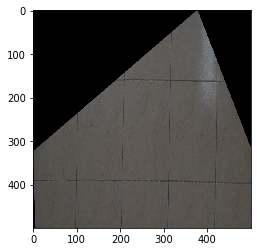

In [6]:

# get_arr_from_H(img,width,height,inv(H_aff)@H_perp,scale=False)
a= get_arr(img,inv(H_aff)@H_perp,(500,500))
plt.imshow(a[:,:,::-1])


[[109 209 109 185]
 [277 148 300 185]
 [332 289 109 335]
 [535 263 300 335]]
[[109 209 109 185]
 [277 148 300 185]
 [332 289 109 335]
 [535 263 300 335]]
[[109 185]
 [300 185]
 [109 335]
 [300 335]]
Homography estimate:  [ 1.50476248e-03 -4.53779052e-03  9.76733769e-01  7.57965758e-04
  1.41034440e-04  2.14379041e-01  1.33035271e-06 -6.85757945e-06
  3.05294732e-03]
600 400
translations added 2632 -70
Maximas :  488 854


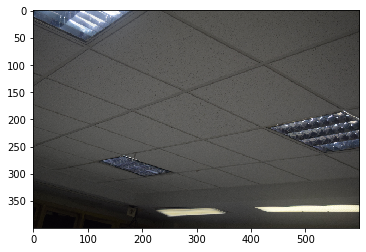

In [7]:
# points2 = np.array([[1096,2096,1120,1856],[2800,1480,2920,1856],\
#                    [3320,2896,1420,4156],[5536,2632,2920,4156]])
points2 = np.array([[1096,2096,1096,1856],[2776,1480,3000,1856],\
                   [3328,2896,1096,3356],[5352,2632,3000,3356]])
img2 = cv2.imread('./Images/Image2.JPG')
img2  = cv2.resize(img2,(img2.shape[1]//10,img2.shape[0]//10))
points2 = points2//10
print(points2)
# img2 = np.pad(img2,((50,50),(50,50),(0,0)),'constant',constant_values=(0,0))
points2 = points2 
print(points2)
plt.imshow(img2[:,:,::-1])


## question1
H2 = get_H(points2)
# print(H2)
print(img2.shape[1],img2.shape[0])
a = get_arr(img2,H2,(3500,2000))

# a = get_arr(img2,H2,(1000,1000),-1400,-40)
plt.imshow(img2[:,:,::-1].astype(int))

True

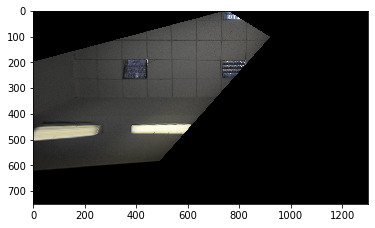

In [10]:
plt.imshow(a[:750,2200:,::-1].astype(int))
cv2.imwrite('img2_1.png',a)

In [12]:
def question2(points,img,width=600,height=400):
    points_ = points.copy()
    if len(points[0])==2:
        points_ = np.hstack([points,np.ones(shape=(4,1))])
        print(points_)
        
    lines = np.stack([get_line(points_[0],points_[1]),get_line(points_[2],points_[3]),\
                    get_line(points_[0],points_[2]),get_line(points_[1],points_[3])])
#     print(lines)
    l_inf = get_l_inf(lines) 
    
#     print(l_inf)
    H_perp = np.array([[1,0,0],[0,1,0],l_inf])
    
    perp = get_arr(img,H_perp,(img.shape[1],img.shape[0]))
#     return perp
    transf_points = get_transf_point(points_,H_perp)
    lines_perp = [np.cross(transf_points[0],transf_points[1]),np.cross(transf_points[0],transf_points[2]),\
                 np.cross(transf_points[0],transf_points[3]),np.cross(transf_points[1],transf_points[2])]
#     print('u',lines_perp[[0,2]])
    s = construct_P(lines_perp[:2],lines_perp[2:])
#     print('S is ',s)
    if len(s.shape)==2:
        if np.sign(s[0][0]*s[2][0]) ==1:
            s= s[:,0]
        else :
            s = s[:,1]
    
    kkt = np.array([[s[0],s[1]],[s[1],s[2]]]).reshape(2,2)
    u,d,_ = svd(kkt)

#     print(u,d)
    k = np.matmul(u,np.diag(np.sqrt(d)))
    k = k*np.sign(k[0][0])
    H_aff = np.array([[k[0][0],k[0][1],0],[k[1][0],k[1][1],0],\
                 [0,0,1]])
    arr = get_arr(img,inv(H_aff)@H_perp,shape=(width,height))
    return arr
# cv2.warpPerspective(img,inv(H_aff)@H_perp,(width,height))
# a = question2(points3_1[:,:2],img3,2000,2000)


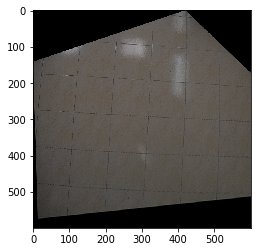

In [23]:
b = a[:600,:600,::-1]
# plt.imshow(cv2.resize(b,(b.shape[1]*2,b.shape[0])))
plt.imshow(b)

## Question 3 

In [9]:
points3 = np.array([[2000,976,3896,568],[3896,568,5040,1968],[5040,1968,3456,1456],[3456,1456,3896,568],\
                    [2000,976,2352,1728],[2352,1728,1144,2056],[1144,2056,2000,976],[2000,976,3456,1456],\
                    [1464,3112,2992,768],[2992,768,5936,1672]])

points_ = point_list[:,:2]
print(points_[2])
def get_five_pairs(points_):
    l1 = get_line(points_[0],points_[1])
    l2 = get_line(points_[1],points_[3])
    l3 = get_line(points_[3],points_[2])
    l4 = get_line(points_[0],points_[2])
    l5 = get_line(points_[0],points_[3])
    l6 = get_line(points_[2],points_[1])
    lines = [l1,l2,l2,l3,l3,l4,l5,l6,l1,l4]

    return lines


[341 390]


In [7]:
# points3 = np.array([[2000,976,3896,568],[3896,568,5040,1968],[5040,1968,3456,1456],[3456,1456,3896,568],\
#                     [2000,976,2352,1728],[2352,1728,1144,2056],[1144,2056,2000,976],[2000,976,3456,1456],\
#                     [1464,3112,2992,768],[2992,768,5936,1672]])
# points3 = np.array()

# points3 = points3//10

# for point in points3:
#     print(point)
# lines3 = [get_line(point[:2],point[2:]) for point in points3]
# print(lines3)


[200  97 389  56]
[389  56 504 196]
[504 196 345 145]
[345 145 389  56]
[200  97 235 172]
[235 172 114 205]
[114 205 200  97]
[200  97 345 145]
[146 311 299  76]
[299  76 593 167]
[array([-0.00154525, -0.00712321,  1.        ]), array([-0.00291545,  0.00239484,  1.        ]), array([ 0.00934066, -0.02912088,  1.        ]), array([-0.00239989, -0.00118646,  1.        ]), array([-0.00646273,  0.00301594,  1.        ]), array([-0.00115518, -0.00423566,  1.        ]), array([-0.00360697, -0.00287222,  1.        ]), array([ 0.01075028, -0.0324748 ,  1.        ]), array([-0.0028696 , -0.00186829,  1.        ]), array([-0.01870504,  0.06043165,  1.        ])]


In [8]:
def get_conic_row(line1,line2):
    row = np.array([line1[0]*line2[0], (line1[0]*line2[1]+line1[1]*line2[0]), line1[1]*line2[1],\
            (line1[0]*line2[2]+ line1[2]*line2[0]), (line1[1]*line2[2]+line1[2]*line2[1]), line1[2]*line2[2]])
    return row
def get_conic(lines):
    # five pairs of perpendicular lines 
    rows = np.array([get_conic_row(lines[2*i],lines[2*i+1]) for i in range(5)])
    print(rows)
    c = null_space(rows)
    print("The coeffs are :",c)
#     c = svd(rows)[2][-1]
    conic = np.array([[c[0],c[1],c[3]],[c[1],c[2],c[4]],[c[3],c[4],c[5]]]).reshape((3,3))
    return conic
# c = get_conic(lines3)   
def get_H_from_conic(conic):
    u,d,v = svd(conic)
    print("The SVD of C is: ",u,'\n',d,'\n',v)
    d[2] = 1
    H = u@np.diag(np.sqrt(d))
    return H

[[ 3.21790210e-06  9.82737983e-06 -1.01309555e-05 -4.01747523e-03
  -1.90244518e-03  1.00000000e+00]
 [ 2.24726683e-06  3.67433993e-06 -4.47960165e-06 -3.68423131e-03
   4.81295868e-04  1.00000000e+00]
 [ 5.06627196e-06  9.95577471e-06 -6.00348224e-06 -7.33794961e-03
   1.28779697e-03  1.00000000e+00]
 [-7.75722878e-06  1.96163971e-05  8.32942400e-06  1.70573566e-03
  -1.16803271e-02  1.00000000e+00]
 [ 7.25448664e-06  2.45495713e-05 -1.35773259e-05 -7.67119353e-03
  -1.09594408e-03  1.00000000e+00]]
The SVD of C is:  [[-9.93587274e-01 -1.13067515e-01 -2.57883939e-04]
 [ 1.13066881e-01 -9.93585776e-01  1.78478280e-03]
 [-4.58030770e-04  1.74417935e-03  9.99998374e-01]] 
 [9.74502800e-01 2.39102658e-01 8.30876396e-16] 
 [[ 9.93587274e-01 -1.13066881e-01  4.58030770e-04]
 [ 1.13067515e-01  9.93585776e-01 -1.74417935e-03]
 [-2.57883939e-04  1.78478280e-03  9.99998374e-01]]
713 609


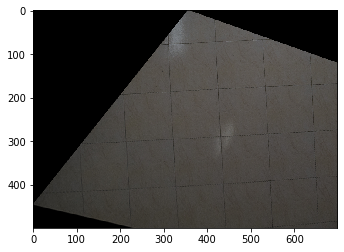

In [10]:
lines = get_five_pairs(points_)
conic = get_conic(lines)
H3 = get_H_from_conic(conic)
rect = get_arr(img,inv(H3),(700,500))
plt.imshow(rect[:,:,::-1])
# plt.imshow(cv2.warpPerspective(img,inv(H3),(2000,2000)))

[[-2.65412694e-05 -1.35525056e-05  1.63992128e-04  1.67096341e-02
  -4.47876259e-02  1.00000000e+00]
 [-7.01984433e-06 -3.90599164e-05  1.22962317e-04  1.77839915e-02
  -4.37811233e-02  1.00000000e+00]
 [-8.15763944e-07 -4.09529188e-06  1.77542394e-05  1.72520661e-03
  -8.90231348e-03  1.00000000e+00]
 [-2.96185449e-06  2.45210743e-05 -9.11429614e-06 -3.91115337e-03
  -3.34443787e-03  1.00000000e+00]
 [-3.08431492e-06  1.03021175e-07  2.36784373e-05  6.50849227e-04
  -9.90881610e-03  1.00000000e+00]]
The SVD of C is:  [[-9.35966967e-01  3.52087556e-01  4.35758988e-04]
 [-3.52087617e-01 -9.35964350e-01 -2.24621023e-03]
 [-3.83007793e-04 -2.25580392e-03  9.99997382e-01]] 
 [1.02288016e+00 1.77169229e-01 9.83522182e-17] 
 [[-9.35966967e-01 -3.52087617e-01 -3.83007793e-04]
 [ 3.52087556e-01 -9.35964350e-01 -2.25580392e-03]
 [ 4.35758988e-04 -2.24621023e-03  9.99997382e-01]]
1900 8551


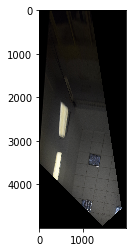

In [56]:
# points3_2 = np.array([[1016,680,208,1224],[208,1224,1808,1832],[1016,680,4200,2160],\
#                      [1808,1832,4232,976],[208,1224,5704,1824],[2808,1480,3144,2368],\
#                      [1808,1832,1016,680],[2808,1488,208,1224],[4224,952,2808,1480],\
#                      [2808,1480,4216,2152]])
# points3_2 = points3_2//4
# lines3_2 = [get_line(point[:2],point[2:]) for point in points3_2]
# print(lines3_2)
lines3_2 = get_five_pairs(points2[:,:2])
conic = get_conic(lines3_2)
H = get_H_from_conic(conic)
# img2 = cv2.imread('./Images/Image2.JPG')
# img2  = cv2.resize(img2,(img2.shape[1]//4,img2.shape[0]//4))
out = get_arr(img2,inv(H),(2000,9000))


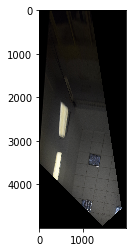

In [57]:
plt.imshow(out[4000:,:,::-1])


In [14]:
points_4 = [[544,1696,540,1600],[1528,1544,1490,1600],[840,2648,540,3096],[2000,2424,1490,3096]]
# points_4 = [[2856,1072,2800,1200],[3720,1160,3368,1200],[2656,1816,2800,2068],\
#            [3680,1920,3668,2068]]
mpoints_4 = [[3856,1864],[4120,2896],[5272,2912],[1512,2832],[2320,2440],\
            [3504,3296],[2704,3816]]
mpoints_4 = np.array(mpoints_4)
points_4 = np.array(points_4)
img4 = cv2.imread('./Images/Image4.JPG')
img4 = cv2.resize(img4,(img4.shape[1]//5,img4.shape[0]//5))
points_4 = points_4//5
mpoints_4 = mpoints_4//5

TR =  [465,486,1]
TL =  [304,565,1]
BL =  [541,764,1]
BR =  [704,660,1]

TL2 = [409,172,1]
BL2 = [274,278,1]
BR2 = [417,320,1]
TR2 = [537,205,1]

l1 = get_line(TR,TL)
l2 = get_line(TR,BR)
l3 = get_line(TL,BR)
l4 = get_line(TR,BL)
l5 = get_line(TR2,TL2)
l6 = get_line(TR2,BR2)
l7 = get_line(TL2,BL2)
l8 = get_line(BR2,BL2)
l9 = get_line(TL,BL)
l10 = get_line(BL,BR)
# print('points_4' ,points_4)
# H = get_H(points_4)
# get_arr_from_H(img4,width,height,H)
# plt.imshow(cv2.warpPerspective(img4,H,(width, height))[:,:,::-1])
points_ = points_4[:,:2]
l1 = get_line(points_[0],points_[1])
l2 = get_line(points_[1],points_[3])
l3 = get_line(points_[1],points_[2])
l4 = get_line(points_[0],points_[3])
print('mpoints' ,mpoints_4)
l5 = get_line(mpoints_4[0],mpoints_4[1])
l6 = get_line(mpoints_4[1],mpoints_4[2])
l7 = get_line(mpoints_4[3],mpoints_4[4])
l8 = get_line(mpoints_4[4],mpoints_4[5])
l9 = get_line(mpoints_4[3],mpoints_4[5])
l10 = get_line(mpoints_4[4],mpoints_4[6])
lines = [l1,l2,l3,l4,l5,l6,l7,l8,l9,l10]
print('The lines are ',lines)

conic = get_conic(lines)
H4 = get_H_from_conic(conic)
a = get_arr(img4,inv(H4),(5000,5000))
transform = np.array([[2,0,0],\
                      [0,2,0],\
                      [0,0,1]])
# a = get_arr(a,transform,(1000,1000),1,1)

mpoints [[ 771  372]
 [ 824  579]
 [1054  582]
 [ 302  566]
 [ 464  488]
 [ 700  659]
 [ 540  763]]
The lines are  [array([-4.42029915e-04, -2.80902882e-03,  1.00000000e+00]), array([-0.00720721,  0.00389025,  1.        ]), array([-0.0020164 , -0.00124999,  1.        ]), array([ 0.00174011, -0.00350422,  1.        ]), array([-1.47982928e-03,  3.78893488e-04,  1.00000000e+00]), array([ 2.29536795e-05, -1.75978209e-03,  1.00000000e+00]), array([-6.76801333e-04, -1.40566431e-03,  1.00000000e+00]), array([ 0.00477334, -0.00658776,  1.        ]), array([ 4.71645485e-04, -2.01843982e-03,  1.00000000e+00]), array([-3.03827117e-03,  8.39667668e-04,  1.00000000e+00])]
[[ 3.18580119e-06  1.85256441e-05 -1.09278353e-05 -7.64923712e-03
   1.08122507e-03  1.00000000e+00]
 [-3.50876919e-06  4.89081584e-06  4.38024037e-06 -2.76293593e-04
  -4.75421287e-03  1.00000000e+00]
 [-3.39675271e-08  2.61287407e-06 -6.66769975e-07 -1.45687560e-03
  -1.38088861e-03  1.00000000e+00]
 [-3.23060038e-06 -2.25110211

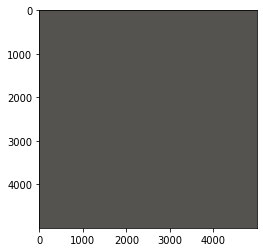

In [81]:
plt.imshow(a[:,:,::-1])

In [18]:
if len(points_[0])==2:
    points_ = np.hstack([points_,np.ones(shape=(4,1))])
    print(points_)
lines = np.stack([get_line(points_[0],points_[1]),get_line(points_[2],points_[3]),\
                get_line(points_[0],points_[2]),get_line(points_[1],points_[3])])
#     print(lines)
l_inf = get_l_inf(lines) 

#     print(l_inf)
H_perp = np.array([[1,0,0],[0,1,0],l_inf])
perp = get_arr(img4,H_perp,(img4.shape[1],img4.shape[0]))
#     return perp

mpoints_4 = np.hstack([mpoints_4,np.ones(shape=(7,1))])
transf_mpoints = get_transf_point(mpoints_4,H_perp)
transf_points = get_transf_point(points_,H_perp)
lines_perp = [np.cross(transf_points[0],transf_points[1]),np.cross(transf_points[0],transf_points[2]),\
             np.cross(transf_mpoints[0],transf_mpoints[1]),np.cross(transf_mpoints[1],transf_mpoints[2])]
#     print('u',lines_perp[[0,2]])
s = construct_P(lines_perp[:2],lines_perp[2:])
print('S is ',s)
if len(s.shape)==2:
    if np.sign(s[0][0]*s[2][0]) ==1:
        s= s[:,0]
    else :
        s = s[:,1]

kkt = np.array([[s[0],s[1]],[s[1],s[2]]]).reshape(2,2)
u,d,_ = svd(kkt)

#     print(u,d)
k = np.matmul(u,np.diag(np.sqrt(d)))
k = k*np.sign(k[0][0])
H_aff = np.array([[k[0][0],k[0][1],0],[k[1][0],k[1][1],0],\
             [0,0,1]])
arr = get_arr(img4,inv(H_aff)@H_perp,shape=(width,height))


[[108. 339.   1.]
 [305. 308.   1.]
 [168. 529.   1.]
 [400. 484.   1.]]
translations added 0 0
Maximas :  1235 351
[[ -831.39056568 -8585.55327346  2780.10910081]
 [  111.57464213 -7868.89542184 -6864.73279452]]
S is  [[ 0.99352682]
 [-0.06635179]
 [ 0.09220573]]
translations added 25 1315
Maximas :  1233 0


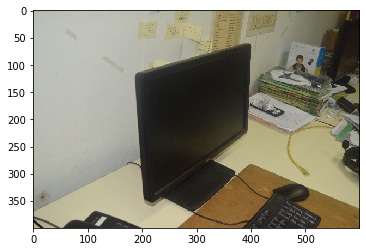

In [32]:
plt.imshow(img5[:,:,::-1])
# cv2.imwrite('img4_q3.png',a[:200,:700])

[[100 130]
 [220 130]
 [100 310]
 [220 310]]
Homography estimate:  [ 1.57968607e-02  9.89998023e-04  4.08928553e-01 -8.29230051e-03
  1.96502923e-02  9.11887854e-01 -2.50845556e-05 -9.84261895e-07
  2.30773407e-02]
translations added -18 525
Maximas :  1458 1051


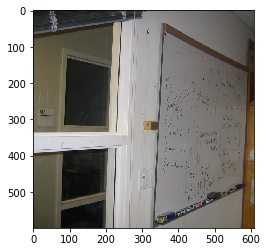

In [40]:
points_6 = [[96,130,100,130],[210,159,220,130],[85,315,100,310],[201,318,220,310]]
points_6 = np.array(points_6)
img6 = cv2.imread('./Images/image6.png')
# img6 = cv2.resize(img6,(img6.shape[1],img4.shape[0]))
points_6 = points_6
H = get_H(points_6)
a = get_arr(img6,H,(1300,1500))
# a = question2(points_6[:,:2],img6,3000,9000)
# lines6_3 = get_five_pairs(points_6[:,:2])
# conic = get_conic(lines6_3)
# H = get_H_from_conic(conic)
# img2 = cv2.imread('./Images/Image2.JPG')
# img2  = cv2.resize(img2,(img2.shape[1]//4,img2.shape[0]//4))
# out = get_arr(img6,inv(H),(3000,3000))
plt.imshow(img6[:,:,::-1])
# plt.imshow(cv2.warpPerspective(img6,H,(img6.shape[1], img4.shape[0]))[:,:,::-1])

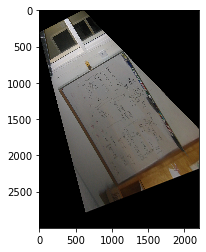

In [28]:
plt.imshow(a[:3000,:2200,::-1])

In [24]:
points5_1 = [[2120,1288,2000,1288],[3912,736,3200,1288],[2232,3352,2000,2488],\
            [3864,2168,3200,2488]]

# mpoints5 = np.array([[3952,96],[4488,32],[3888,512],[4320,424]])
mpoints5 = np.array([[2024,1192],[3984,640],[2192,3520],[3920,2240]])
mpoints5 = np.array(mpoints5)
img5 = cv2.imread('./Images/Image5.JPG')
img5 = cv2.resize(img5,(img5.shape[1]//10,img5.shape[0]//10))
points5_1 = points5_1//10
mpoints5 = mpoints5//10
# points5_1 = [[213,130],[392,76],[224,338],[390,220]]
# points5_1 = np.array(points5_1)



points_ = points5_1[:,:2]
print(points_)
print(mpoints5)
if len(points_[0])==2:
    points_ = np.hstack([points_,np.ones(shape=(4,1))])
    mpoints5 = np.hstack([mpoints5,np.ones(shape=(4,1))])
    
lines = np.stack([get_line(points_[0],points_[1]),get_line(points_[2],points_[3]),\
                get_line(points_[0],points_[2]),get_line(points_[1],points_[3])])
#     print(lines)
l_inf = get_l_inf(lines) 

#     print(l_inf)
H_perp = np.array([[1,0,0],[0,1,0],l_inf])
perp = get_arr(img5,H_perp,(img5.shape[1]*5,img5.shape[0]*5))
#     return perp

transf_mpoints = get_transf_point(mpoints5,H_perp)
transf_points = get_transf_point(points_,H_perp)
lines_perp = [np.cross(transf_points[0],transf_points[1]),np.cross(transf_points[0],transf_points[2]),\
             np.cross(transf_mpoints[0],transf_mpoints[2]),np.cross(transf_mpoints[2],transf_mpoints[3])]
#     print('u',lines_perp[[0,2]])
s = construct_P(lines_perp[:2],lines_perp[2:])
print('S is ',s)
if len(s.shape)==2:
    if np.sign(s[0][0]*s[2][0]) ==1:
        s= s[:,0]
    else :
        s = s[:,1]

kkt = np.array([[s[0],s[1]],[s[1],s[2]]]).reshape(2,2)
u,d,_ = svd(kkt)

#     print(u,d)
k = np.matmul(u,np.diag(np.sqrt(d)))
k = k*np.sign(k[0][0])
H_aff = np.array([[k[0][0],k[0][1],0],[k[1][0],k[1][1],0],\
             [0,0,1]])
arr = get_arr(img5,inv(H_aff)@H_perp,shape=(11000,6000))
# transform = np.array([[1,0,0],[0,-1,0],[0,0,1]])
# arr = cv2.warpPerspective(img,transform,(5000,9000))


TypeError: unsupported operand type(s) for //: 'list' and 'int'

[array([  -117,   -362, 143494]), array([    413,     -23, -168306]), array([  -117,   -362, 143494]), array([  -293,    -14, 231714]), array([  -237,   -325, 324190]), array([    413,     -23, -168306]), array([  -320,    -11, 256404]), array([  -262,   -350, 361332]), array([  -262,   -350, 361332]), array([    465,     -35, -178030])]
[[      -48321      -146815         8326     78954824     57626410
  -24150901164]
 [       34281       107704         5068    -69154280    -85889384
   33249568716]
 [      -97881      -128774         7475    173778992     47243080
  -54563122140]
 [       83840       114882         3850   -182804088    -93716052
   92646970128]
 [     -121830      -153580        12250    214663240     49663880
  -64327935960]]
The coeffs are : [[-9.58508303e-01]
 [ 9.94994927e-02]
 [ 2.67135294e-01]
 [-6.37106815e-04]
 [ 1.11788976e-04]
 [-4.11099728e-07]]
The SVD of C is:  [[-9.96763078e-01 -8.03921764e-02 -6.81765607e-04]
 [ 8.03923059e-02 -9.96763287e-01 -1.645369

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f55a81e8a60> (for post_execute):


KeyboardInterrupt: 

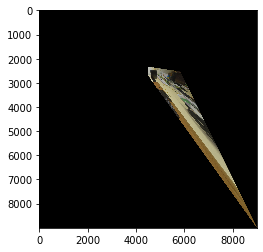

In [32]:
points5_1 = [[2120,1288,2000,1288],[3912,736,3200,1288],[2232,3352,2000,2488],\
            [3864,2168,3200,2488]]

# mpoints5 = np.array([[3952,96],[4488,32],[3888,512],[4320,424]])
mpoints5 = np.array([[2024,1192],[3984,640],[2192,3520],[3920,2240]])
mpoints5 = np.array(mpoints5)
points5_1 = np.array(points5_1)
img5 = cv2.imread('./Images/Image5.JPG')
img5 = cv2.resize(img5,(img5.shape[1]//5,img5.shape[0]//5))
points5_1 = points5_1//5
mpoints5 = mpoints5//10
# points5_1 = [[213,130],[392,76],[224,338],[390,220]]
# points5_1 = np.array(points5_1)
points_ = points5_1[:,:2]
c = np.cross
# l1 = get_line(points_[0],points_[1])
# l2 = get_line(points_[1],points_[3])
# l3 = get_line(points_[1],points_[2])
# l4 = get_line(points_[0],points_[3])
# # print('mpoints' ,mpoints_4)
# l5 = get_line(points_[0],points_[2])
# l6 = get_line(points_[2],points_[3])
# l7 = get_line(mpoints5[1],mpoints5[3])
# l8 = get_line(mpoints5[2],mpoints5[3])
# l9 = get_line(mpoints5[0],mpoints5[3])
# l10 = get_line(mpoints5[1],mpoints5[2])
# TR =  [784,143,1]
# TL =  [422,260,1]
# BL =  [445,673,1]
# BR =  [770,436,1]

# TR2 = [797,124,1]
# TL2 = [401,241,1]
# BL2 = [436,706,1]
# BR2 = [786,444,1]

TR =  [784,143,1]
TL =  [422,260,1]
BL =  [445,673,1]
BR =  [770,436,1]

TR2 = [797,124,1]
TL2 = [401,241,1]
BL2 = [436,706,1]
BR2 = [786,444,1]
# TR =  [465,486,1]
# TL =  [304,565,1]
# BL =  [541,764,1]
# BR =  [704,660,1]

# TL2 = [409,172,1]
# BL2 = [274,278,1]
# BR2 = [417,320,1]
# TR2 = [537,205,1]
top_line = c(TR,TL)
bottom_line = c(BR,BL)
right_line = c(TR,BR)
left_line = c(BL,TL)
diag1 = c(TR,BL)
diag2 = c(TL,BR)

#top_top_line = c(corner,TTRL)

l = [top_line ,top_line,bottom_line,c(TR2,BR2),c(BR2,BL2)]
m = [left_line,right_line,left_line,c(BR2,BL2),c(BL2,TL2)]
lines = [l[0],m[0],l[1],m[1],l[2],m[2],l[3],m[3],l[4],m[4]]
print(lines)
conic = get_conic(lines)
H5 = get_H_from_conic(conic)
transform = [[1/5,0,0],[0,1/5,0],[0,0,1]]
transform = np.array(transform)
print(transform)
print(type(transform[0,0]))
# print(type(inv(H5))[0,0])
a = get_arr(img5,transform@inv(H5),(9000,9000))
plt.imshow(np.flip(np.flip(a[:,:,::-1],axis=0),axis=1))

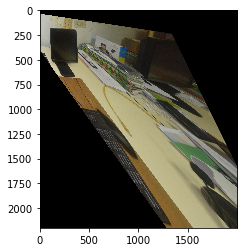

In [90]:
plt.imshow(np.flip(np.flip(a[:,:,::-1],axis=0),axis=1)[2300:4500,4500:6500])

pin [[236 173]
 [441 120]
 [341 390]
 [581 292]
 [420 260]]
[[236. 173.   1.]
 [441. 120.   1.]
 [341. 390.   1.]
 [581. 292.   1.]
 [420. 260.   1.]]
translations added 0 0
Maximas :  708 256
(5, 6)
(1, 6)
c [[-6.22645930e-06]
 [ 5.89201644e-06]
 [ 3.10146285e-05]
 [ 8.72056114e-04]
 [-7.25711873e-03]
 [ 9.99973286e-01]]
The SVD of C is:  [[-0.98828345  0.15262969  0.        ]
 [ 0.15262969  0.98828345  0.        ]
 [ 0.          0.          1.        ]] 
 [10.25449141  2.29228753  0.        ] 
 [[ 0.98828345 -0.15262969  0.        ]
 [ 0.15262969  0.98828345  0.        ]
 [ 0.          0.          1.        ]]
[[-3.164744    0.23108596  0.        ]
 [ 0.48876048  1.49629102  0.        ]
 [ 0.          0.          1.        ]]
translations added 219 0
Maximas :  11 206


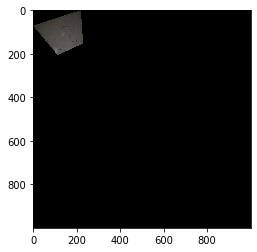

In [50]:
points_ = point_list[:,:2].copy()
point = [4208,2600]
point = np.array(point)//10

# points_ = points2[:,:2].copy()
# point = [1504,1712]
# point = np.array(point)//10

# points_ = points_6[:,:2]
# point = [165,105]
# point = np.array(point)
# points_ = [[2856,1080],[3720,1160],[2656,1824],[3680,1920],[3304,976]]
# points_ = points_4[:,:2].copy()
# point = [936,1448]
# points_ = np.array(points_)//
points_ = np.vstack([points_,np.array(point).reshape(-1,2)])
print("pin",points_)
if len(points_[0])==2:
    points_ = np.hstack([points_,np.ones(shape=(5,1))])
    print(points_)

lines = np.stack([get_line(points_[0],points_[1]),get_line(points_[2],points_[3]),\
                get_line(points_[0],points_[2]),get_line(points_[1],points_[3])])
l_inf = get_l_inf(lines) 
H_perp = np.array([[1,0,0],[0,1,0],l_inf])
perp = get_arr(img,H_perp,(width,height))
transf_points = get_transf_point(points_,H_perp)
cx,cy,_ = (transf_points[0] + transf_points[3])/2
rows = []
for point in transf_points:
    row = [point[0]**2,2*point[0]*point[1],point[1]**2,2*point[0],2*point[1],1]
    rows.append(row)
rows = np.array(rows)
print(rows.shape)
row_ = np.array([cx,cy,0,1,0,0]).reshape(-1,6)  
print(row_.shape)
A = rows
c = null_space(A)
print('c',c)
c = c[:,0]
c = c/c[0]
# u,d,vh = svd(A)
# c = vh[-1]
# c = c/c[0]
# conic = np.array([[c[0],c[2],c[3]],[c[2],c[1],c[4]],[c[3],c[4],c[5]]])
# point_i =  np.array([point_i,1,0]).reshape(-1,1)
# point_j = np.array([1,point_j,0]).reshape(-1,1)
conic = np.array([[2*c[2],-1*2*c[1],0],[-2*c[1],2,0],[0,0,0]])
H = get_H_from_conic(conic)
print(H)
a = get_arr(img,inv(H)@H_perp,(1000,1000))
plt.imshow(a[:,:,::-1])

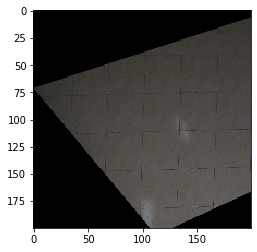

In [52]:
plt.imshow(a[:200,:200,::-1])


[[ 96. 130.   1.]
 [210. 159.   1.]
 [ 85. 315.   1.]
 [201. 318.   1.]]
translations added 0 0
Maximas :  1929 1900
(4, 6)
(1, 6)
The SVD of C is:  [[-0.92087046 -0.3898687   0.        ]
 [-0.3898687   0.92087046  0.        ]
 [ 0.          0.          1.        ]] 
 [7.65132807 0.98704492 0.        ] 
 [[-0.92087046 -0.3898687  -0.        ]
 [-0.3898687   0.92087046  0.        ]
 [ 0.          0.          1.        ]]
[[-2.5472229  -0.38733508  0.        ]
 [-1.07841715  0.91488604  0.        ]
 [ 0.          0.          1.        ]]
translations added 5649 1924
Maximas :  0 561


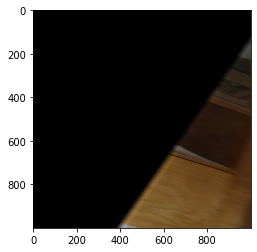

In [94]:
points_ = points_6[:,:2].copy()
if len(points_[0])==2:
    points_ = np.hstack([points_,np.ones(shape=(4,1))])
    print(points_)

lines = np.stack([get_line(points_[0],points_[1]),get_line(points_[2],points_[3]),\
                get_line(points_[0],points_[2]),get_line(points_[1],points_[3])])
l_inf = get_l_inf(lines) 
H_perp = np.array([[1,0,0],[0,1,0],l_inf])
perp = get_arr(img6,H_perp,(width,height))
transf_points = get_transf_point(points_,H_perp)
cx,cy,_ = (transf_points[0] + transf_points[3])/2
rows = []
for point in transf_points:
    row = [point[0]**2,2*point[0]*point[1],point[1]**2,2*point[0],2*point[1],1]
    rows.append(row)
rows = np.array(rows)
print(rows.shape)
row_ = np.array([cx,cy,0,1,0,0]).reshape(-1,6)  
print(row_.shape)
A = np.vstack([rows,row_])
# c = null_space(A)
# c = c[:,0]
# c = c/c[0]
u,d,vh = svd(A)
c = vh[-1]
c = c/c[0]
# conic = np.array([[c[0],c[2],c[3]],[c[2],c[1],c[4]],[c[3],c[4],c[5]]])
# point_i =  np.array([point_i,1,0]).reshape(-1,1)
# point_j = np.array([1,point_j,0]).reshape(-1,1)
conic = np.array([[2*c[2],-1*2*c[1],0],[-2*c[1],2,0],[0,0,0]])
H = get_H_from_conic(conic)
print(H)
a = get_arr(img6,H@H_perp,(1000,1000))
plt.imshow(a[:,:,::-1])